### Email SPAM/HAM Classification 

### Download dataset from Kaggle 
- Data: https://www.kaggle.com/venky73/spam-mails-dataset
- To download data from Kaggle, you need to authenticate with the Kaggle services. For this purpose, you need an API token. This token can be easily generated from the profile section of your Kaggle account -> Create new api token
- Reference: https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/

In [1]:
#Install the Kaggle library
!pip install kaggle

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
#Allocate the required permission for this file
!chmod 600 ~/.kaggle/kaggle.json

The syntax of the command is incorrect.
'cp' is not recognized as an internal or external command,
operable program or batch file.
'chmod' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
#Download
!kaggle datasets download venky73/spam-mails-dataset

Traceback (most recent call last):
  File "C:\Users\mohit\anaconda3\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\mohit\anaconda3\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\mohit\anaconda3\Scripts\kaggle.exe\__main__.py", line 4, in <module>
  File "C:\Users\mohit\anaconda3\lib\site-packages\kaggle\__init__.py", line 23, in <module>
    api.authenticate()
  File "C:\Users\mohit\anaconda3\lib\site-packages\kaggle\api\kaggle_api_extended.py", line 403, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in C:\Users\mohit\.kaggle. Or use the environment method.


In [4]:
!unzip spam-mails-dataset.zip

'unzip' is not recognized as an internal or external command,
operable program or batch file.


- Try: Downloading Gmail mbox dataset

#Steps:
- Step 1: Understand the data
- Step 2: Preprocessing
  - Stop-Word Removal
  - Lower Casing
  - Stemming
  - Lemmatization
  - Tokenization
- Step 3: BAG OF WORDS
- Step 4: TF-IDF
- Step 5: Train Model
- Step 6: Evaluation

#Imports

In [5]:
#Basic
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
import re

#Text processing
import nltk as nl
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer 

#Feature extraction and data preparation for model
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split

#Model
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.neural_network import MLPClassifier

#Evaluation
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score


In [6]:
#Download resources from nltk
nl.download('wordnet')
nl.download('omw-1.4')
nl.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mohit\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\mohit\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mohit\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer("english")
lemmatizer = WordNetLemmatizer()

#Text preprocessing methods

## Stop words
- Stopwords are the most common words in any natural language. For the purpose of analyzing text data and building NLP models, these stopwords might not add much value to the meaning of the document.

In [8]:
print(stop_words[:10])
print("No of stop words: ", len(stop_words))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]
No of stop words:  179


#Stemming
- Stemming, also called suffix stripping, is a technique used to reduce text dimensionality. Stemming is also a type of text normalization that enables you to standardize some words into specific expressions also called stems.

In [9]:
# choose some words to be stemmed
words = ["program", "programs", "programmer", "programming", "programmers"]
#words = ["likes", "liked", "likely", "liking"]
# words = ['amazement', 'amaze', 'amazed']
for w in words:
    print(w, " : ", stemmer.stem(w))

program  :  program
programs  :  program
programmer  :  programm
programming  :  program
programmers  :  programm


## Lemmatization
- Lemmatization is the process of grouping together the different inflected forms of a word so they can be analyzed as a single item. Lemmatization is similar to stemming but it brings context to the words. So it links words with similar meanings to one word. 

In [10]:
words = ["program", "programs", "programmer", "programming", "programmers"]
#words = ["likes", "liked", "likely", "liking"]
#words = ['amazement', 'amaze', 'amazed']
for w in words:
    print(w, " : ", lemmatizer.lemmatize(w))

lemmatizer.lemmatize(words[2])

program  :  program
programs  :  program
programmer  :  programmer
programming  :  programming
programmers  :  programmer


'programmer'

In [11]:
print("better :", lemmatizer.lemmatize("better", pos ="a"))

better : good


#Dataset

In [12]:
dataset = pd.read_csv("spam_ham_dataset.csv")

In [13]:
dataset.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [14]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5171 non-null   int64 
 1   label       5171 non-null   object
 2   text        5171 non-null   object
 3   label_num   5171 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 161.7+ KB


In [15]:
#Remove secondary fields
dataset_mails = dataset.drop(dataset.columns[0:2],axis=1)
dataset_mails.head()

,text,label_num
0,Subject: enron methanol ; meter # : 988291\r\n...,0
1,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,"Subject: photoshop , windows , office . cheap ...",1
4,Subject: re : indian springs\r\nthis deal is t...,0


In [16]:
dataset_mails.shape

(5171, 2)

#Clean text

In [17]:
#The clean text function allows you to convert all letters to lowercase, 
#remove numbers, punctuation and all words that have less than 3 characters
def clean_text(text):
    new_text=text.lower()
    clean_text= re.sub("[^a-z]+"," ",new_text)
    clean_text_stop_removed = ""
    for w in clean_text.split(" ")[1:]:
        if not w in stop_words and len(w) > 3:
            clean_text_stop_removed += w
            clean_text_stop_removed += " "
            clean_text_stop_removed=lemmatizer.lemmatize(clean_text_stop_removed)
            clean_text_stop_removed=stemmer.stem(clean_text_stop_removed)
    return clean_text_stop_removed


In [18]:
print(dataset_mails['text'][4])

Subject: re : indian springs
this deal is to book the teco pvr revenue . it is my understanding that teco
just sends us a check , i haven ' t received an answer as to whether there is a
predermined price associated with this deal or if teco just lets us know what
we are giving . i can continue to chase this deal down if you need .


In [19]:
print(clean_text(dataset_mails['text'][4]))

indian springs deal book teco revenue understanding teco sends check received answer whether predermined price associated deal teco lets know giving continue chase deal need 


In [20]:
#Apply the function on total dataset
dataset_mails["text_clean"] = dataset_mails.text.apply(clean_text)

In [21]:
dataset_mails.head()

,text,label_num,text_clean
0,Subject: enron methanol ; meter # : 988291\r\n...,0,enron methanol meter follow note gave monday p...
1,"Subject: hpl nom for january 9 , 2001\r\n( see...",0,january attached file hplnol hplnol
2,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0,neon retreat around wonderful time year neon l...
3,"Subject: photoshop , windows , office . cheap ...",1,photoshop windows office cheap main trending a...
4,Subject: re : indian springs\r\nthis deal is t...,0,indian springs deal book teco revenue understa...


In [22]:
dataset_mails_clean = dataset_mails.drop(dataset_mails.columns[0:1],axis=1)

In [23]:
#Add length feature
dataset_mails_clean['len'] = dataset_mails_clean['text_clean'].str.len()

In [24]:
dataset_mails_clean.head()

,label_num,text_clean,len
0,0,enron methanol meter follow note gave monday p...,202
1,0,january attached file hplnol hplnol,36
2,0,neon retreat around wonderful time year neon l...,1294
3,1,photoshop windows office cheap main trending a...,387
4,0,indian springs deal book teco revenue understa...,174


#Visualization

In [25]:
count_Class=pd.value_counts(dataset_mails_clean["label_num"], sort= True)
count_Class

0    3672
1    1499
Name: label_num, dtype: int64

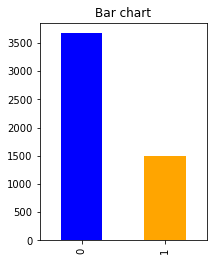

In [26]:
#Bar plot of class labels
plt.rcParams['figure.figsize'] = (3, 4)
count_Class.plot(kind= 'bar', color= ["blue", "orange"])
plt.title('Bar chart')
plt.show()

##Visualization of text length in spam and non-spam

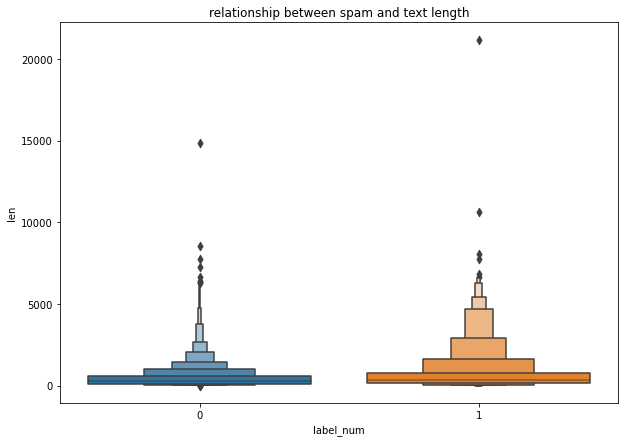

In [27]:
# It is similar to a box plot in plotting a nonparametric representation 
#of a distribution in which all features correspond to actual observations. 
#By plotting more quantiles, it provides more information about the shape 
#of the distribution, particularly in the tails.
plt.rcParams['figure.figsize'] = (10, 7)
sns.boxenplot(x = dataset_mails_clean['label_num'], y = dataset_mails_clean['len'])
plt.title('relationship between spam and text length')
plt.show()

##Word frequency

In [28]:
count1 = Counter(" ".join(dataset_mails_clean[dataset_mails_clean['label_num']==0]["text_clean"]).split()).most_common(20)
df1 = pd.DataFrame.from_dict(count1)
df1 = df1.rename(columns={0: "words in non-spam", 1 : "count"})
count2 = Counter(" ".join(dataset_mails_clean[dataset_mails_clean['label_num']==1]["text_clean"]).split()).most_common(20)
df2 = pd.DataFrame.from_dict(count2)
df2 = df2.rename(columns={0: "words in spam", 1 : "count_"})
print(df1)
df2

   words in non-spam  count
0              enron   6555
1               deal   2789
2            subject   2731
3             please   2715
4              meter   2459
5              daren   1901
6             thanks   1813
7               corp   1710
8               know   1438
9              mmbtu   1349
10         forwarded   1296
11              need   1257
12            farmer   1137
13          attached   1083
14          contract    883
15            volume    877
16             would    875
17            robert    875
18            sitara    861
19             texas    796


,words in spam,count_
0,http,983
1,company,728
2,information,520
3,font,515
4,please,483
5,statements,476
6,email,474
7,price,471
8,nbsp,418
9,height,362


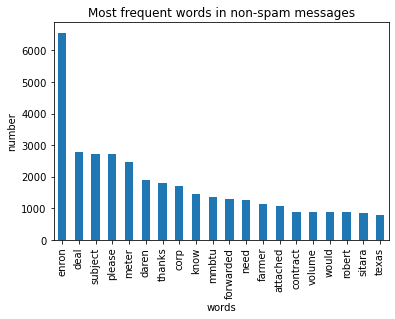

In [29]:
plt.rcParams['figure.figsize'] = (6, 4)
df1.plot.bar(legend = False)
y_pos = np.arange(len(df1["words in non-spam"]))
plt.xticks(y_pos, df1["words in non-spam"])
plt.title('Most frequent words in non-spam messages')
plt.xlabel('words')
plt.ylabel('number')
plt.show()

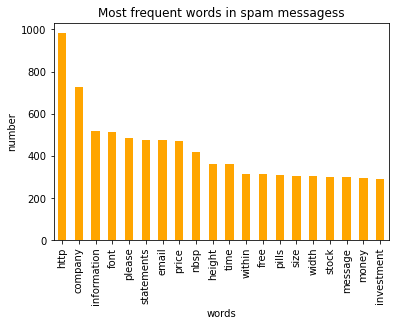

In [30]:
plt.rcParams['figure.figsize'] = (6, 4)
df2.plot.bar(legend = False, color = 'orange')
y_pos = np.arange(len(df2["words in spam"]))
plt.xticks(y_pos, df2["words in spam"])
plt.title('Most frequent words in spam messagess')
plt.xlabel('words')
plt.ylabel('number')
plt.show()


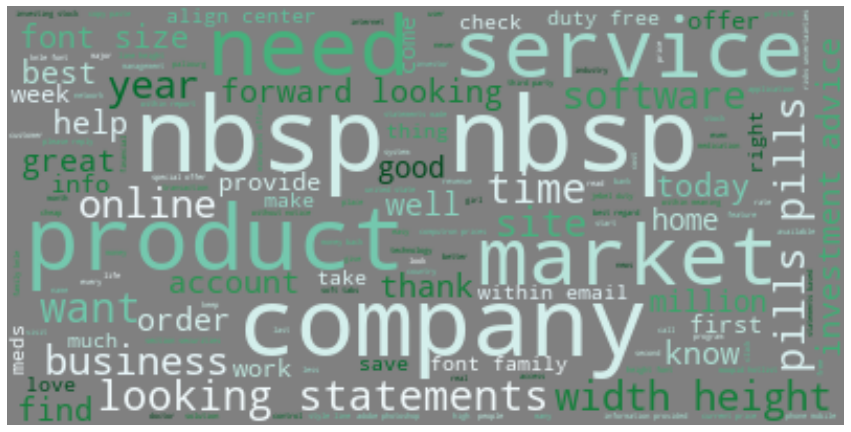

In [31]:
from wordcloud import WordCloud
# text = ' '.join(dataset_mails_clean.text_clean.values)
text = ' '.join(dataset_mails_clean[dataset_mails_clean['label_num']==1].text_clean.values)

wordcloud = WordCloud(max_font_size=50, max_words=1000, background_color="grey",  colormap='BuGn').generate(text.lower())
plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#Train Test Data

In [32]:
x = dataset_mails_clean['text_clean']
y = dataset_mails_clean['label_num']

In [33]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.2)

In [34]:
print(x_train.shape, x_test.shape)

(4136,) (1035,)


In [35]:
print("Samples per class in train {}".format(np.bincount(y_train)))
print("Samples per class in test {}".format(np.bincount(y_test)))

Samples per class in train [2922 1214]
Samples per class in test [750 285]


#Feature Extraction: Bag of words

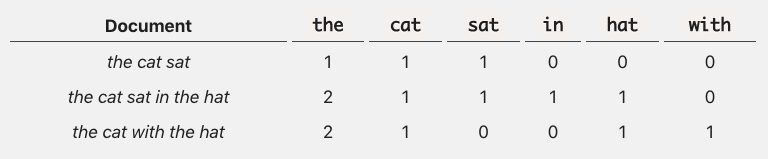

In [36]:
bow_vec = TfidfVectorizer()
train_bow = bow_vec.fit_transform(x_train)
test_bow = bow_vec.transform(x_test) #Why only transform?

In [37]:
cv_df = pd.DataFrame(train_bow.toarray(),columns = bow_vec.get_feature_names_out())
cv_df.head()

,aaas,aabvmmq,aachecar,aaer,aafco,aaiabe,aaigrcrb,aaihmqv,aaldano,aalland,...,zyjvit,zykfe,zynsdirnh,zynve,zyqtaqlt,zyrtec,zyyqywp,zzocb,zzso,zzsyt
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
feature_names = bow_vec.get_feature_names_out()
print("Number of features: {}".format(len(feature_names)))

Number of features: 38021


- Try: TF-IDF Feature 
  - tfidf = TfidfVectorizer()



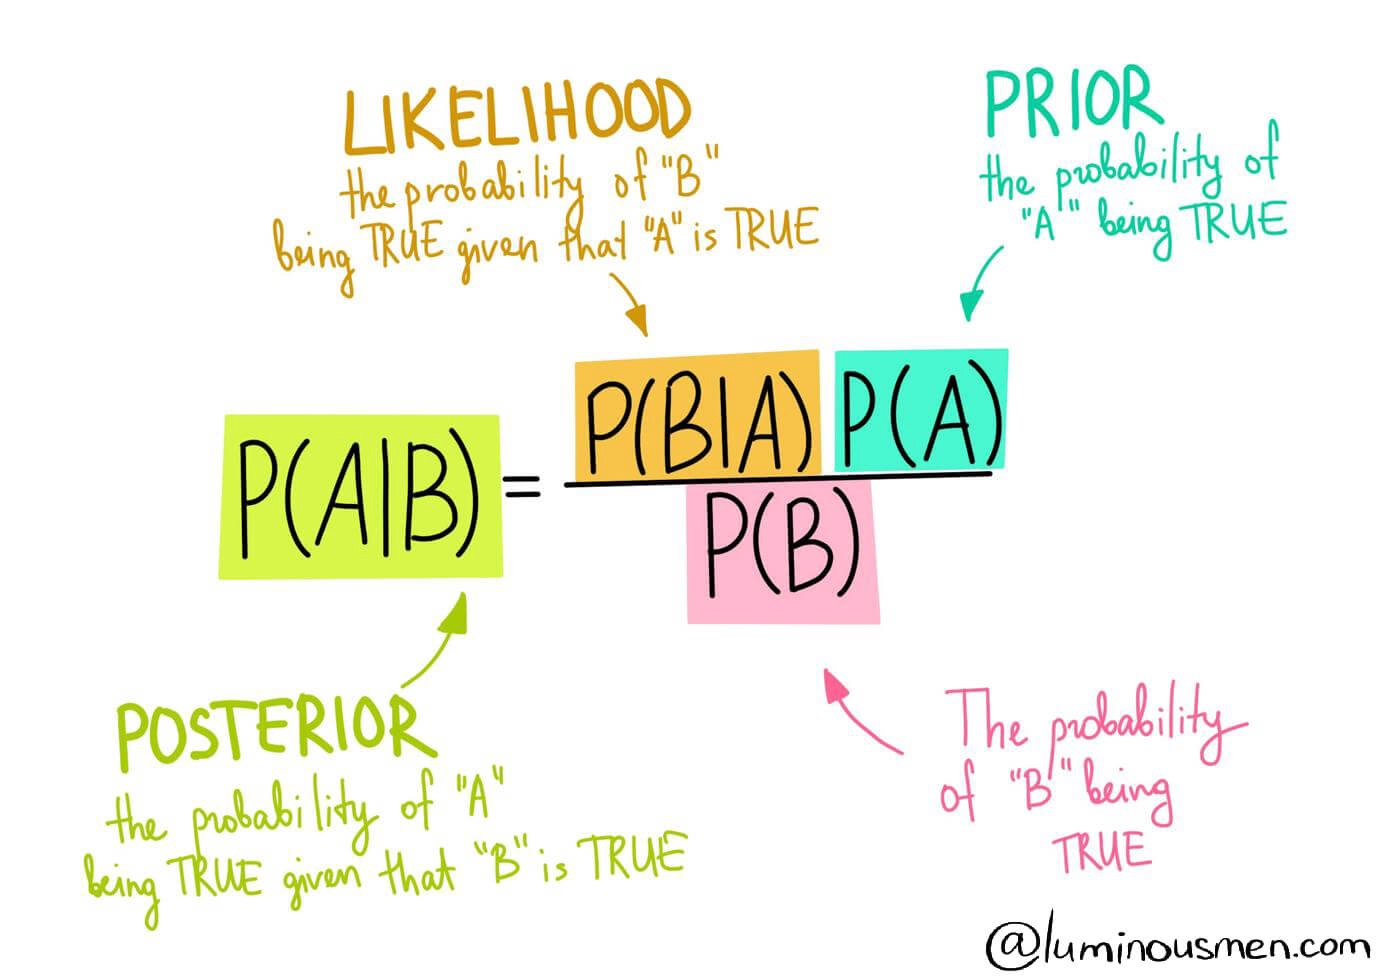

In [39]:
# clf = MultinomialNB()#SVC()
# clf.fit(X_train, y_train)
# y_pred=clf.predict(X_test)
# accuracy_score (y_test,y_pred )

In [40]:
## Preparing to make a pipeline 
models = {
    'Naive Bayes': MultinomialNB(),
    'Bernoulli Naive Bayes': BernoulliNB(),
    'Perceptron': MLPClassifier()
}

params = {
    'Naive Bayes': { 'alpha': [0.01, 0.1, 1, 10], 'fit_prior': [True, False] },
    'Bernoulli Naive Bayes': { 'alpha': [0.5, 1], 'fit_prior': [True, False] },
    'Perceptron': { 'activation': ['tanh', 'relu'] }
}

In [41]:
# Use multiple classifiers and grid search for prediction
def ML_modeling(models, params, X_train, X_test, y_train, y_test, performance_metrics):    
    
    if not set(models.keys()).issubset(set(params.keys())):
        raise ValueError('Some estimators are missing parameters')

    for key in models.keys():
    
        model = models[key]
        param = params[key]

        gs = GridSearchCV(model, param, cv=10, error_score=0, refit=True)
        gs.fit(X_train, y_train)
        y_pred = gs.predict(X_test)
        
        # Print scores for the classifier
        accuracy_sc = accuracy_score(y_test, y_pred)
        precision_sc= precision_score(y_test, y_pred, average='macro')
        recall_sc = recall_score(y_test, y_pred, average='macro')
        f1_sc =  f1_score(y_test, y_pred, average='macro')
        
        performance_metrics.append([key,accuracy_sc,precision_sc,recall_sc,f1_sc])
        print(key, ':', gs.best_params_)
        print("Accuracy: %1.3f \tPrecision: %1.3f \tRecall: %1.3f \t\tF1: %1.3f\n" % (accuracy_sc, precision_sc, recall_sc, f1_sc))
        
    return 

In [42]:
performance_metrics_bow = []
print("==============Bag of Words==============\n")
ML_modeling(models, params, train_bow, test_bow, y_train, y_test, performance_metrics_bow)
metrics_bow_df = pd.DataFrame(performance_metrics_bow,columns=['Model' , 'Accuracy', 'Precision' , 'Recall', "F1 Score"])

==============Bag of Words==============

Naive Bayes : {'alpha': 0.1, 'fit_prior': False}
Accuracy: 0.981 	Precision: 0.972 	Recall: 0.980 		F1: 0.976

Bernoulli Naive Bayes : {'alpha': 0.5, 'fit_prior': False}
Accuracy: 0.855 	Precision: 0.871 	Recall: 0.756 		F1: 0.789

Perceptron : {'activation': 'relu'}
Accuracy: 0.989 	Precision: 0.986 	Recall: 0.987 		F1: 0.987



C:\Users\mohit\AppData\Local\Temp\ipykernel_17404\669358154.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


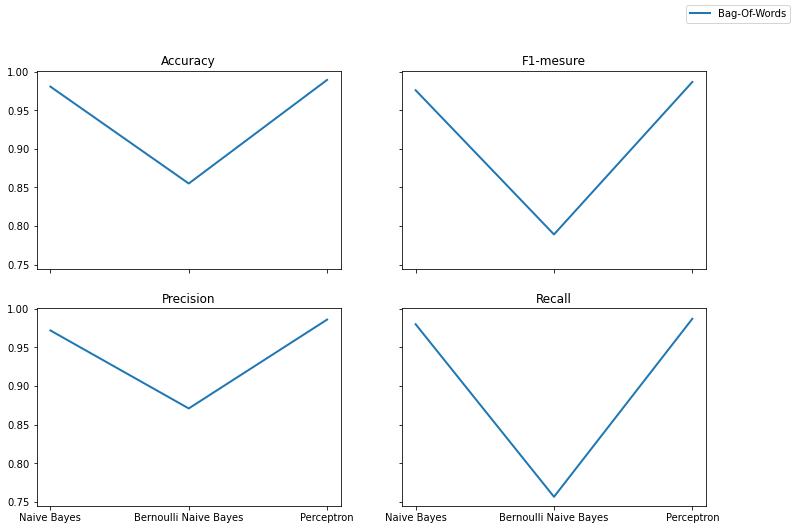

In [43]:
f, axes = plt.subplots(2, 2, figsize=(12,8), sharey = True, sharex = True)

axes[0, 0].plot(metrics_bow_df['Model'], metrics_bow_df['Accuracy'], linestyle = 'solid', linewidth = 2, label = 'Bag-Of-Words')
axes[0, 0].set_title('Accuracy')

axes[0, 1].plot(metrics_bow_df['Model'], metrics_bow_df['F1 Score'], linestyle = 'solid', linewidth = 2)
axes[0, 1].set_title('F1-mesure')

axes[1, 0].plot(metrics_bow_df['Model'], metrics_bow_df['Precision'], linestyle = 'solid', linewidth = 2)
axes[1, 0].set_title('Precision')

axes[1, 1].plot(metrics_bow_df['Model'], metrics_bow_df['Recall'], linestyle = 'solid', linewidth = 2)
axes[1, 1].set_title('Recall')

f.legend()
f.show()

#Othe features

In [44]:
from gensim.models import Word2Vec
from tqdm import tqdm
from warnings import filterwarnings
filterwarnings('ignore')

In [45]:
words_in_sentences=[]
for i in tqdm(x_train):
    words_in_sentences.append(i.split())

100%|██████████████████████████████████████████████████████████████████████████| 4136/4136 [00:00<00:00, 137911.74it/s]


In [46]:
wv_model = Word2Vec(sentences=words_in_sentences,workers=-1)

In [47]:
wv_model.wv.most_similar('lottery', topn=10)

[('happenstance', 0.36441636085510254),
 ('tammy', 0.32255667448043823),
 ('guests', 0.3164374530315399),
 ('baker', 0.31254181265830994),
 ('food', 0.310580849647522),
 ('diligence', 0.3058513104915619),
 ('ambien', 0.29244014620780945),
 ('potentia', 0.28905999660491943),
 ('balancing', 0.2868880331516266),
 ('phillips', 0.28540322184562683)]

In [48]:
print(len(wv_model.wv.get_vector('company')))
print(wv_model.wv.get_vector('company'))

100
[-0.00950012  0.00956222 -0.00777076 -0.00264551 -0.00490641 -0.0049667
 -0.00802359 -0.00778358 -0.00455321 -0.00127536 -0.00510299  0.00614054
 -0.00951662 -0.0053071   0.00943715  0.00699133  0.00767581  0.00423474
  0.00050709 -0.00598114  0.00601878  0.00263503  0.00769943  0.00639384
  0.00794257  0.00865741 -0.00989576 -0.0067557   0.00133757  0.0064403
  0.00737381  0.00551698  0.00766162 -0.00512557  0.00658441 -0.00410837
 -0.00905534  0.00914168  0.0013314  -0.00275968 -0.00247784 -0.00422048
  0.00481234  0.00440022 -0.00265336 -0.00734188 -0.00356585 -0.00033662
  0.00609589 -0.00283734 -0.00012089  0.00087973 -0.00709565  0.002065
 -0.00143242  0.00280215  0.00484222 -0.00135202 -0.00278014  0.00773865
  0.0050456   0.00671352  0.00451564  0.00866715  0.00747497 -0.00108189
  0.00874764  0.00460172  0.00544063 -0.00138608 -0.00204132 -0.00442435
 -0.0085152   0.00303773  0.00888319  0.00891974 -0.00194236  0.00608616
  0.00377972 -0.00429597  0.00204292 -0.00543789  0

In [49]:
vocab=list(wv_model.wv.index_to_key)
print(len(vocab))

7007


In [50]:
def avg_w2vec(sentences):
    transformed=[]
    for sentence in tqdm(sentences):
        count=0
        vector=np.zeros(100)
        for word in sentence.split():
            if word in vocab:
                vector+=wv_model.wv.get_vector(word)
                count+=1
        if count!=0:
            vector/=count
            transformed.append(vector)
        else:
            # print(sentence)
            transformed.append(np.random.rand(100))
    
    return np.array(transformed)

In [51]:
x_train_transformed=avg_w2vec(x_train)
x_test_transformed=avg_w2vec(x_test)

100%|█████████████████████████████████████████████████████████████████████████████| 1035/1035 [00:02<00:00, 397.42it/s]


In [52]:
## Preparing to make a pipeline 
models = {
    # 'Naive Bayes': MultinomialNB(),
    # 'Bernoulli Naive Bayes': BernoulliNB(),
    'Perceptron': MLPClassifier()
}

params = {
    # 'Naive Bayes': { 'alpha': [0.5, 1], 'fit_prior': [True, False] },
    # 'Bernoulli Naive Bayes': { 'alpha': [0.5, 1], 'fit_prior': [True, False] },
    'Perceptron': { 'activation': ['tanh', 'relu'] }
}

- Can we use Naive Bayes?

In [53]:
performance_metrics_wv = []
print("============== Word2vec ==============\n")
ML_modeling(models, params, x_train_transformed, x_test_transformed, y_train, y_test, performance_metrics_wv)
metrics_bow_df = pd.DataFrame(performance_metrics_wv,columns=['Model' , 'Accuracy', 'Precision' , 'Recall', "F1 Score"])

============== Word2vec ==============

Perceptron : {'activation': 'tanh'}
Accuracy: 0.841 	Precision: 0.807 	Recall: 0.780 		F1: 0.792

